In [1]:
import tensorflow as tf 
import numpy as np 
import os 

E:\Anaconda\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Anaconda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
E:\Anaconda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
img_dims = (160,160)
batch_size = 8
data_fp = 'shape_classifier_data'
num_class = len(os.listdir(data_fp))

print(f'Generating non-augmenting generator from {data_fp} with flow_from_dir to create batch sizes of {batch_size} and dims {img_dims}. There are {num_class} classes')
datagen = train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        data_fp,
        # All images will be resized to 150x150
        target_size=img_dims,
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training')   

validation_generator = train_datagen.flow_from_directory(
    data_fp, # same directory as training data
    target_size=img_dims,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data   

Generating non-augmenting generator from shape_classifier_data with flow_from_dir to create batch sizes of 8 and dims (160, 160). There are 3 classes
Found 6870 images belonging to 3 classes.
Found 1716 images belonging to 3 classes.


In [17]:
from classifier import *

model = gen_model((160,160,3),num_class)

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
history = model.fit(train_generator,epochs=6,validation_data=validation_generator)

Epoch 1/6
859/859 [==============================] - 38s 44ms/step - loss: 0.4600 - accuracy: 0.8028 - val_loss: 0.0653 - val_accuracy: 0.9703
Epoch 2/6
859/859 [==============================] - 37s 43ms/step - loss: 0.0748 - accuracy: 0.9736 - val_loss: 0.0522 - val_accuracy: 0.9749
Epoch 3/6
859/859 [==============================] - 39s 45ms/step - loss: 0.0628 - accuracy: 0.9772 - val_loss: 0.0903 - val_accuracy: 0.9732
Epoch 4/6
859/859 [==============================] - 46s 53ms/step - loss: 0.0560 - accuracy: 0.9790 - val_loss: 0.0521 - val_accuracy: 0.9779
Epoch 5/6
859/859 [==============================] - 45s 52ms/step - loss: 0.0425 - accuracy: 0.9839 - val_loss: 0.0489 - val_accuracy: 0.9825
Epoch 6/6
859/859 [==============================] - 53s 61ms/step - loss: 0.0267 - accuracy: 0.9883 - val_loss: 0.0616 - val_accuracy: 0.9773


<AxesSubplot:>

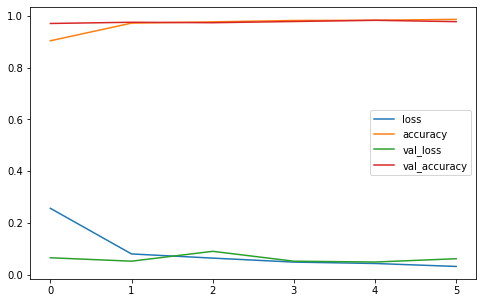

In [24]:
import matplotlib
import pandas as pd 
pd.DataFrame(history.history).plot(figsize=(8,5))
# plt.show()

In [25]:
import cv2

In [26]:
img = cv2.imread('./shape_classifier_data/rectangle/14.png')

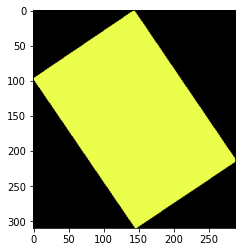

In [29]:
from matplotlib import pyplot as plt
plt.imshow(img)

In [54]:

def test_print_predict(image_path):
    img = cv2.imread(image_path)
#     print(img)
    pred = model.predict(np.expand_dims(resize_and_rescale(img),axis=0), batch_size =1)
        
    print(pred)
    plt.grid(False)
    plt.imshow(img)
    return pred

In [55]:
pred_classes= train_generator.class_indices.keys()

In [56]:
pred_classes

dict_keys(['circle', 'rectangle', 'triangle'])

[[9.9997687e-01 6.6283218e-07 2.2423745e-05]]


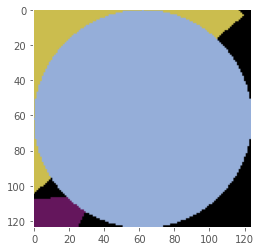

In [58]:
preds= test_print_predict('./shape_classifier_data/circle/14.png')

In [82]:
def test_image_predictions(filepaths,pred_classes,model):

    if type(filepaths) != list:
        filepaths = [filepaths]
    #Infer the required input dims from the model itself
    img_dims = model.layers[0].input.shape[1],model.layers[0].input.shape[2]

    resize_and_rescale = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(img_dims[0],img_dims[1]),
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)
    ])

    subplots = (len(filepaths),2) #always 2 cols (img, graph), rows of n based on image count  
    plt.figure(figsize=(24,6*len(filepaths))) #size a plot to match num_in

    i=0
    for filepath in filepaths:
        #Probably better to predict in batches but oh well
        img = cv2.imread(filepath)
#     print(img)
        pred = model.predict(np.expand_dims(resize_and_rescale(img),axis=0), batch_size =1)
        #print image
        ax = plt.subplot(subplots[0], subplots[1], i+1)
        plt.imshow(img)
        plt.axis("off")
        #print prediction graph
        ax = plt.subplot(subplots[0], subplots[1], i + 2)
        plt.bar(pred_classes, pred[0]*100, label="confidence")
        plt.title("Predictions")
        plt.xlabel("Type")
        plt.ylabel("% confidence")
        i+=2

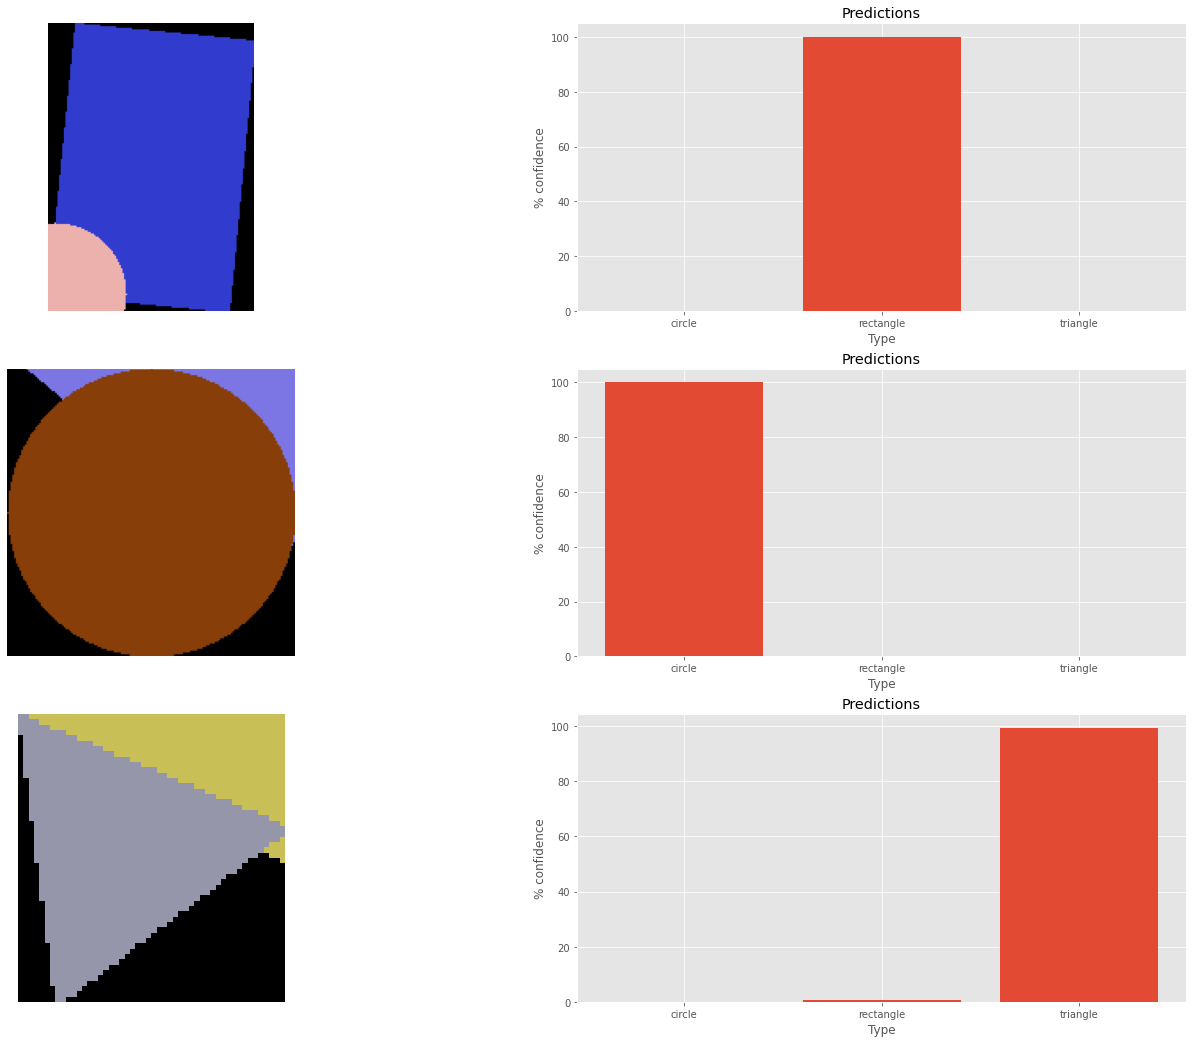

In [94]:
test_image_predictions(['./shape_classifier_data/rectangle/325.png',
                        './shape_classifier_data/circle/25.png',
                        './shape_classifier_data/triangle/123.png'],
                        pred_classes,
                        model)

In [49]:
save_model('first_pass',model)

INFO:tensorflow:Assets written to: ./SavedModels/first_pass\assets


True